In [2]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model

# Define a CNN-based autoencoder
def create_cnn_autoencoder():
    input_layer = Input(shape=(1000, 6, 1))  # Adjust the input shape

    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2), padding='same')(x)
    # ... add more layers as needed

    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    # ... add more layers as needed

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_layer, decoded)
    return autoencoder

DIR = "../data/Raw/logRaws/"

NUM_SAMPLES = 2662
NUM_FEATURES = 6
NUM_FRAMES = 1000

file_names = os.listdir(DIR)
input_array = np.empty((NUM_SAMPLES, NUM_FRAMES, NUM_FEATURES))

# prepare data
def read_files(DIR):
    all_files = os.listdir(DIR)

    input_data = np.empty((0, 6), float)

    for file in all_files:
        file_path = os.path.join(DIR, file)
        df = pd.read_csv(file_path, usecols=[1, 19, 20, 21, 25, 26, 27], header=None)
        if df.shape[0] < 999:
            continue

        df.columns = ['frame', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
        df_input = df[['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']]
        df_input = df_input.astype('float32')

        input_data = np.append(input_data, df_input, axis=0)
    input_data = input_data.reshape(NUM_SAMPLES, NUM_FRAMES, NUM_FEATURES)

    return input_data

input_data = read_files(DIR)

print(input_data.shape)


2023-11-28 20:26:56.184917: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 20:26:56.707937: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 20:26:56.710802: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 20:26:58.022117: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Assume input_data is your raw data reshaped as (NUM_SAMPLES, NUM_FRAMES, NUM_FEATURES)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
# Reshape for scaling
data_reshaped_for_scaling = input_data.reshape(-1, NUM_FEATURES)
scaler.fit(data_reshaped_for_scaling)
data_normalized = scaler.transform(data_reshaped_for_scaling)
# Reshape back to original format
data_normalized = data_normalized.reshape(NUM_SAMPLES, NUM_FRAMES, NUM_FEATURES)

# Add a channel dimension for CNN compatibility
data_cnn = np.expand_dims(data_normalized, axis=3)

# Split data
X_train, X_test = train_test_split(data_cnn, test_size=0.2, random_state=42)

# Create and compile the CNN autoencoder
autoencoder = create_cnn_autoencoder()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))


NameError: name 'input_data' is not defined

17/17 [==============================] - 0s 15ms/step


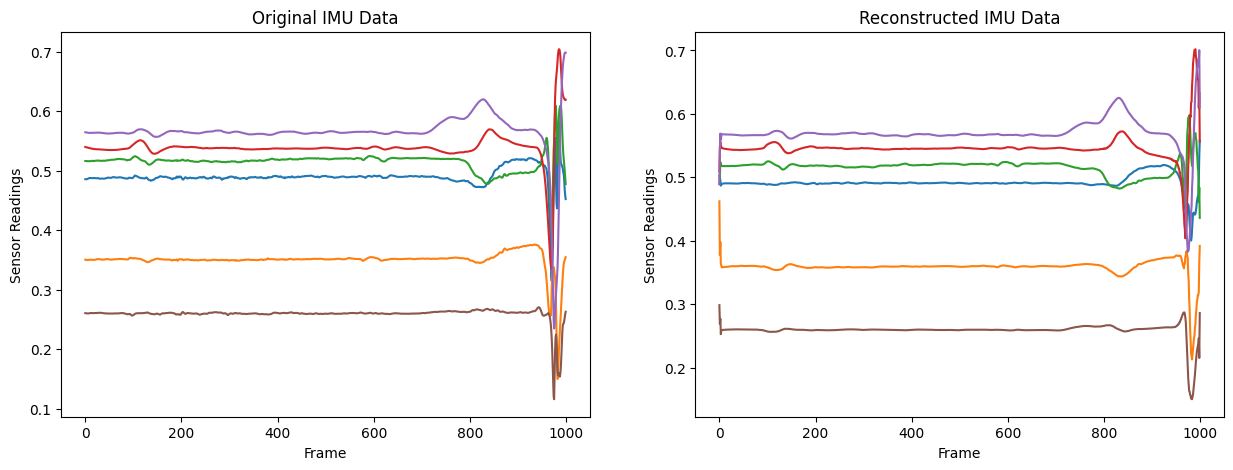

In [ ]:
import matplotlib.pyplot as plt

# Assuming X_test is your test data and autoencoder is your trained model

# Reconstruct the data using the autoencoder
reconstructed_data = autoencoder.predict(X_test)

# Reshape reconstructed data if necessary (remove the channel dimension)
reconstructed_data = reconstructed_data.reshape(reconstructed_data.shape[0], NUM_FRAMES, NUM_FEATURES)

# Select a sample to visualize
sample_index = 0  # for example, the first sample in the dataset
original_sample = X_test[sample_index].reshape(NUM_FRAMES, NUM_FEATURES)
reconstructed_sample = reconstructed_data[sample_index]

# Plotting
plt.figure(figsize=(15, 5))

# Original Data
plt.subplot(1, 2, 1)
plt.plot(original_sample)
plt.title("Original IMU Data")
plt.xlabel("Frame")
plt.ylabel("Sensor Readings")

# Reconstructed Data
plt.subplot(1, 2, 2)
plt.plot(reconstructed_sample)
plt.title("Reconstructed IMU Data")
plt.xlabel("Frame")
plt.ylabel("Sensor Readings")

plt.show()


In [ ]:
import tensorflow as tf

# save model
export_path = "./autoencoder/1"
tf.saved_model.save(autoencoder, export_path)